![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/5.Text_Classification_with_ClassifierDL.ipynb)

# Text Classification with ClassifierDL

**Relevant blogpost:** https://towardsdatascience.com/text-classification-in-spark-nlp-with-bert-and-universal-sentence-encoders-e644d618ca32

## Colab Setup

In [1]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4
! pip install --ignore-installed -q spark-nlp==2.6.2

openjdk version "1.8.0_265"
OpenJDK Runtime Environment (build 1.8.0_265-8u265-b01-0ubuntu2~18.04-b01)
OpenJDK 64-Bit Server VM (build 25.265-b01, mixed mode)



<b>  if you want to work with Spark 2.3 </b>
```
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://archive.apache.org/dist/spark/spark-2.3.0/spark-2.3.0-bin-hadoop2.7.tgz

!tar xf spark-2.3.0-bin-hadoop2.7.tgz
!pip install -q findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
os.environ["SPARK_HOME"] = "/content/spark-2.3.0-bin-hadoop2.7"
! java -version

import findspark
findspark.init()
from pyspark.sql import SparkSession

! pip install --ignore-installed -q spark-nlp==2.5.5

import sparknlp

spark = sparknlp.start(spark23=True)
```

In [2]:
import sparknlp

spark = sparknlp.start(gpu=True) # for GPU training >> sparknlp.start(gpu = True) # for Spark 2.3 =>> sparknlp.start(spark23 = True)

from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

spark

Spark NLP version 2.6.2
Apache Spark version: 2.4.4


## Using Pretrained ClassifierDL and SentimentDL models

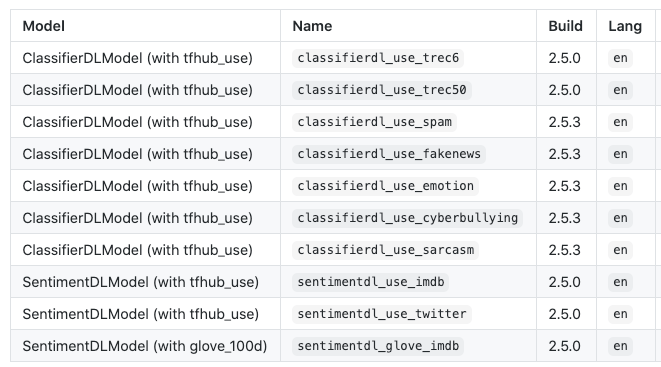

In [17]:
fake_classifier = ClassifierDLModel.pretrained('classifierdl_use_fakenews', 'en') \
                .setInputCols(["document", "sentence_embeddings"]) \
                .setOutputCol("class")

classifierdl_use_fakenews download started this may take some time.
Approximate size to download 21.4 MB
[OK!]


fake_news classifier is trained on `https://raw.githubusercontent.com/joolsa/fake_real_news_dataset/master/fake_or_real_news.csv.zip`

In [42]:
fake_classifier.getClasses()

['FAKE', 'REAL']

In [20]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

use = UniversalSentenceEncoder.pretrained(lang="en") \
  .setInputCols(["document"])\
  .setOutputCol("sentence_embeddings")

nlpPipeline = Pipeline(stages=[
  documentAssembler, 
  use,
  fake_classifier
  ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

fake_clf_model = nlpPipeline.fit(empty_data)



tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [5]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/data/spam_ham_dataset.csv

In [21]:
fake_lp_pipeline = LightPipeline(fake_clf_model)

text = 'BREAKING: Leaked Picture Of Obama Being Dragged Before A Judge In Handcuffs For Wiretapping Trump'

fake_lp_pipeline.annotate(text)

{'class': ['FAKE'],
 'document': ['BREAKING: Leaked Picture Of Obama Being Dragged Before A Judge In Handcuffs For Wiretapping Trump'],
 'sentence_embeddings': ['BREAKING: Leaked Picture Of Obama Being Dragged Before A Judge In Handcuffs For Wiretapping Trump']}

In [23]:
sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+-------------------------------------------------------------------------------------------------+
|text                                                                                             |
+-------------------------------------------------------------------------------------------------+
|BREAKING: Leaked Picture Of Obama Being Dragged Before A Judge In Handcuffs For Wiretapping Trump|
+-------------------------------------------------------------------------------------------------+



In [25]:
pred = fake_clf_model.transform(sample_data)

pred.show()

+--------------------+--------------------+--------------------+--------------------+
|                text|            document| sentence_embeddings|               class|
+--------------------+--------------------+--------------------+--------------------+
|BREAKING: Leaked ...|[[document, 0, 96...|[[sentence_embedd...|[[category, 0, 96...|
+--------------------+--------------------+--------------------+--------------------+



In [28]:
pred.select('text','class.result').show(truncate=False)

+-------------------------------------------------------------------------------------------------+------+
|text                                                                                             |result|
+-------------------------------------------------------------------------------------------------+------+
|BREAKING: Leaked Picture Of Obama Being Dragged Before A Judge In Handcuffs For Wiretapping Trump|[FAKE]|
+-------------------------------------------------------------------------------------------------+------+



you can find more samples here >> `https://github.com/KaiDMML/FakeNewsNet/tree/master/dataset`


## Generic classifier function

In [43]:
def get_clf_lp(model_name, sentiment_dl=False, pretrained=True):

  documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

  use = UniversalSentenceEncoder.pretrained(lang="en") \
  .setInputCols(["document"])\
  .setOutputCol("sentence_embeddings")


  if pretrained:

    if sentiment_dl:

      document_classifier = SentimentDLModel.pretrained(model_name, 'en') \
                .setInputCols(["document", "sentence_embeddings"]) \
                .setOutputCol("class")
    else:
      document_classifier = ClassifierDLModel.pretrained(model_name, 'en') \
                .setInputCols(["document", "sentence_embeddings"]) \
                .setOutputCol("class")

  else:

    if sentiment_dl:

      document_classifier = SentimentDLModel.load(model_name) \
                .setInputCols(["document", "sentence_embeddings"]) \
                .setOutputCol("class")
    else:
      document_classifier = ClassifierDLModel.load(model_name) \
                .setInputCols(["document", "sentence_embeddings"]) \
                .setOutputCol("class")

  print ('classes:',document_classifier.getClasses())

  nlpPipeline = Pipeline(stages=[
  documentAssembler, 
  use,
  document_classifier
  ])

  empty_data = spark.createDataFrame([[""]]).toDF("text")

  clf_pipelineFit = nlpPipeline.fit(empty_data)

  clf_lp_pipeline = LightPipeline(clf_pipelineFit)

  return clf_lp_pipeline


In [44]:
clf_lp_pipeline = get_clf_lp('classifierdl_use_trec50')

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_trec50 download started this may take some time.
Approximate size to download 21.2 MB
[OK!]
classes: [' ENTY_color', ' ENTY_techmeth', ' DESC_manner', ' NUM_volsize', ' ENTY_letter', ' NUM_temp', ' ENTY_body', ' NUM_count', ' ENTY_instru', ' NUM_period', ' NUM_speed', ' DESC_reason', ' ENTY_symbol', ' ENTY_event', ' HUM_desc', ' NUM_perc', ' ENTY_dismed', ' NUM_ord', ' HUM_gr', ' LOC_mount', ' ABBR_abb', ' DESC_desc', ' NUM_dist', ' HUM_title', ' ENTY_lang', ' ENTY_sport', ' ENTY_plant', ' NUM_code', ' NUM_other', ' ENTY_word', ' ENTY_animal', ' ENTY_substance', ' ENTY_veh', ' ENTY_product', ' LOC_state', ' ENTY_religion', ' ENTY_currency', ' NUM_date', ' LOC_country', ' ENTY_cremat', ' NUM_money', ' LOC_other', ' DESC_def', ' LOC_city', ' HUM_ind', ' ENTY_other', ' ENTY_termeq', ' ENTY_food', ' ABBR_exp', ' NUM_weight']


trained on the TREC datasets:

Classify open-domain, fact-based questions into one of the following broad semantic categories: 

```Abbreviation, Description, Entities, Human Beings, Locations or Numeric Values.```

In [31]:
text = 'What was the number of member nations of the U.N. in 2000?'

clf_lp_pipeline.annotate(text)['class']

[' NUM_count']

In [6]:
clf_lp_pipeline.fullAnnotate(text)[0]['class'][0].result

' NUM_count'

In [32]:
clf_lp_pipeline.fullAnnotate(text)[0]['class'][0].metadata

{' ENTY_dismed': '1.7313898E-26', ' ENTY_product': '3.63476E-27', ' ENTY_techmeth': '2.2640923E-26', ' NUM_speed': '1.3080189E-26', ' NUM_volsize': '6.7228085E-28', ' LOC_state': '6.3383686E-30', ' NUM_code': '1.3392521E-26', ' NUM_count': '0.99992645', ' ENTY_food': '3.1855655E-29', ' ENTY_animal': '3.249227E-28', ' NUM_period': '3.884492E-25', ' ENTY_religion': '1.2567391E-26', ' LOC_country': '7.536532E-24', ' LOC_mount': '5.677046E-28', ' ENTY_termeq': '6.9578083E-29', ' ENTY_color': '2.3618112E-27', ' ENTY_lang': '1.1541806E-28', ' ENTY_sport': '1.5911332E-29', ' DESC_def': '1.6701288E-29', ' HUM_gr': '7.091323E-24', ' ENTY_symbol': '3.147325E-28', ' ENTY_currency': '5.094744E-33', ' ENTY_veh': '2.9945387E-28', ' LOC_other': '6.047787E-16', ' ENTY_word': '1.3657634E-29', ' NUM_temp': '4.717617E-28', ' NUM_dist': '2.72894E-29', ' DESC_desc': '1.7242685E-14', ' DESC_manner': '5.3869763E-25', ' NUM_ord': '1.0586534E-31', ' NUM_other': '5.864289E-31', ' DESC_reason': '1.5721332E-15', 

In [33]:
text = 'What animal was the first mammal successfully cloned from adult cells?'

clf_lp_pipeline.annotate(text)['class']

[' HUM_ind']

In [45]:
clf_lp_pipeline = get_clf_lp('classifierdl_use_cyberbullying')


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_cyberbullying download started this may take some time.
Approximate size to download 21.4 MB
[OK!]
classes: ['sexism', 'neutral', 'racism']


In [35]:
text ='RT @EBeisner @ahall012 I agree with you!! I would rather brush my teeth with sandpaper then watch football with a girl!!'

clf_lp_pipeline.annotate(text)['class']

['sexism']

In [46]:
clf_lp_pipeline = get_clf_lp('classifierdl_use_fakenews')


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_fakenews download started this may take some time.
Approximate size to download 21.4 MB
[OK!]
classes: ['FAKE', 'REAL']


In [37]:
text ='Donald Trump a KGB Spy? 11/02/2016 In today’s video, Christopher Greene of AMTV reports Hillary Clinton campaign accusation that Donald Trump is a KGB spy is about as weak and baseless a claim as a Salem witch hunt or McCarthy era trial. It’s only because Hillary Clinton is losing that she is lobbing conspiracy theory. Citizen Quasar The way I see it, one of two things will happen: 1. Trump will win by a landslide but the election will be stolen via electronic voting, just like I have been predicting for over a decade, and the American People will accept the skewed election results just like they accept the TSA into their crotches. 2. Somebody will bust a cap in Hillary’s @$$ killing her and the election will be postponed. Follow AMTV!'

clf_lp_pipeline.annotate(text)['class']


['FAKE']

In [38]:
text ='Sen. Marco Rubio (R-Fla.) is adding a veteran New Hampshire political operative to his team as he continues mulling a possible 2016 presidential bid, the latest sign that he is seriously preparing to launch a campaign later this year.Jim Merrill, who worked for former GOP presidential nominee Mitt Romney and ran his 2008 and 2012 New Hampshire primary campaigns, joined Rubio’s fledgling campaign on Monday, aides to the senator said.Merrill will be joining Rubio’s Reclaim America PAC to focus on Rubio’s New Hampshire and broader Northeast political operations."Marco has always been well received in New Hampshire, and should he run for president, he would be very competitive there," Terry Sullivan, who runs Reclaim America, said in a statement. "Jim certainly knows how to win in New Hampshire and in the Northeast, and will be a great addition to our team at Reclaim America.”News of Merrill’s hire was first reported by The New York Times.'

clf_lp_pipeline.annotate(text)['class']

['REAL']

In [47]:
sentiment_lp_pipeline = get_clf_lp('sentimentdl_use_twitter', sentiment_dl=True)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.9 MB
[OK!]
classes: ['positive', 'negative']


In [40]:
text ='I am SO happy the news came out in time for my birthday this weekend! My inner 7-year-old cannot WAIT!'

sentiment_lp_pipeline.annotate(text)['class']

['positive']

In [48]:
sentiment_lp_pipeline = get_clf_lp('classifierdl_use_emotion', sentiment_dl=False)


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_emotion download started this may take some time.
Approximate size to download 20.7 MB
[OK!]
classes: ['joy', 'fear', 'surprise', 'sadness']


In [49]:
sentiment_lp_pipeline.annotate(text)['class']

['surprise']

## ClassiferDL with Word Embeddings and Text Preprocessing

### Load Dataset

In [3]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/data/news_category_train.csv
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/data/news_category_test.csv

In [ ]:
!ls -lt

total 24948
-rw-r--r-- 1 root root  1504408 Jul 27 12:56 news_category_test.csv
-rw-r--r-- 1 root root 24032125 Jul 27 12:56 news_category_train.csv
drwxr-xr-x 1 root root     4096 Jul 10 16:29 sample_data


In [4]:
trainDataset = spark.read \
      .option("header", True) \
      .csv("news_category_train.csv")

trainDataset.show(truncate=50)

+--------+--------------------------------------------------+
|category|                                       description|
+--------+--------------------------------------------------+
|Business| Short sellers, Wall Street's dwindling band of...|
|Business| Private investment firm Carlyle Group, which h...|
|Business| Soaring crude prices plus worries about the ec...|
|Business| Authorities have halted oil export flows from ...|
|Business| Tearaway world oil prices, toppling records an...|
|Business| Stocks ended slightly higher on Friday but sta...|
|Business| Assets of the nation's retail money market mut...|
|Business| Retail sales bounced back a bit in July, and n...|
|Business|" After earning a PH.D. in Sociology, Danny Baz...|
|Business| Short sellers, Wall Street's dwindling  band o...|
|Business| Soaring crude prices plus worries  about the e...|
|Business| OPEC can do nothing to douse scorching  oil pr...|
|Business| Non OPEC oil exporters should consider  increa...|
|Busines

In [52]:
trainDataset.count()


120000

In [5]:
from pyspark.sql.functions import col

trainDataset.groupBy("category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------+-----+
|category|count|
+--------+-----+
|   World|30000|
|Sci/Tech|30000|
|  Sports|30000|
|Business|30000|
+--------+-----+



In [6]:
testDataset = spark.read \
      .option("header", True) \
      .csv("news_category_test.csv")


testDataset.groupBy("category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------+-----+
|category|count|
+--------+-----+
|Sci/Tech| 1900|
|   World| 1900|
|  Sports| 1900|
|Business| 1900|
+--------+-----+



In [ ]:
# if we want to split the dataset
'''
(trainingData, testData) = trainDataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
'''

In [7]:
document_assembler = DocumentAssembler() \
    .setInputCol("description") \
    .setOutputCol("document")
    
tokenizer = Tokenizer() \
  .setInputCols(["document"]) \
  .setOutputCol("token")
    
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)

lemma = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma")


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


### with Glove 100d embeddings

In [8]:

glove_embeddings = WordEmbeddingsModel().pretrained() \
 .setInputCols(["document",'lemma'])\
 .setOutputCol("embeddings")\
 .setCaseSensitive(False)

embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["document", "embeddings"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE")

classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("category")\
  .setMaxEpochs(3)\
  .setEnableOutputLogs(True)
  #.setOutputLogsPath('logs')

clf_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            lemma, 
            glove_embeddings,
            embeddingsSentence,
            classsifierdl])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
'''
default classifierDL params:

maxEpochs -> 10,
lr -> 5e-3f,
dropout -> 0.5f,
batchSize -> 64,
enableOutputLogs -> false,
verbose -> Verbose.Silent.id,
validationSplit -> 0.0f,
outputLogsPath -> ""
'''

In [9]:
# Train (8 min for 10 epochs)
%%time

clf_pipelineModel = clf_pipeline.fit(trainDataset)

CPU times: user 101 ms, sys: 17.6 ms, total: 119 ms
Wall time: 3min 13s


In [ ]:
!cd ~/annotator_logs && ls -l


total 4
-rw-r--r-- 1 root root 976 Apr  7 16:59 ClassifierDLApproach_f222663dfb2c.log


In [ ]:
!cat ~/annotator_logs/ClassifierDLApproach_f222663dfb2c.log


Training started - total epochs: 10 - learning rate: 0.005 - batch size: 64 - training examples: 120000
Epoch 0/10 - 35.42044908%.2fs - loss: 1637.3722 - accuracy: 0.8689917 - batches: 1875
Epoch 1/10 - 36.031757286%.2fs - loss: 1609.2766 - accuracy: 0.88155836 - batches: 1875
Epoch 2/10 - 34.908468392%.2fs - loss: 1603.4879 - accuracy: 0.886125 - batches: 1875
Epoch 3/10 - 34.849212057%.2fs - loss: 1596.2185 - accuracy: 0.889725 - batches: 1875
Epoch 4/10 - 34.979911249%.2fs - loss: 1592.2081 - accuracy: 0.89270836 - batches: 1875
Epoch 5/10 - 35.059568873%.2fs - loss: 1588.2047 - accuracy: 0.89515835 - batches: 1875
Epoch 6/10 - 34.855471653%.2fs - loss: 1583.6277 - accuracy: 0.8974583 - batches: 1875
Epoch 7/10 - 34.498874087%.2fs - loss: 1579.1383 - accuracy: 0.89934164 - batches: 1875
Epoch 8/10 - 35.507189799%.2fs - loss: 1575.4302 - accuracy: 0.90068334 - batches: 1875
Epoch 9/10 - 34.665519006%.2fs - loss: 1572.7279 - accuracy: 0.9023167 - batches: 1875


In [12]:
# get the predictions on test Set

preds = clf_pipelineModel.transform(testDataset)


In [13]:
preds.select('category','description',"class.result").show(10, truncate=80)


+--------+--------------------------------------------------------------------------------+----------+
|category|                                                                     description|    result|
+--------+--------------------------------------------------------------------------------+----------+
|Business|Unions representing workers at Turner   Newall say they are 'disappointed' af...|[Business]|
|Sci/Tech| TORONTO, Canada    A second team of rocketeers competing for the  #36;10 mil...|[Sci/Tech]|
|Sci/Tech| A company founded by a chemistry researcher at the University of Louisville ...|[Sci/Tech]|
|Sci/Tech| It's barely dawn when Mike Fitzpatrick starts his shift with a blur of color...|[Sci/Tech]|
|Sci/Tech| Southern California's smog fighting agency went after emissions of the bovin...|[Sci/Tech]|
|Sci/Tech|"The British Department for Education and Skills (DfES) recently launched a "...|[Sci/Tech]|
|Sci/Tech|"confessed author of the Netsky and Sasser viruses, is responsi

In [ ]:
preds_df = preds.select('category','description',"class.result").toPandas()

# The result is an array since in Spark NLP you can have multiple sentences.
# Let's explode the array and get the item(s) inside of result column out
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])


In [ ]:
# We are going to use sklearn to evalute the results on test dataset
from sklearn.metrics import classification_report

print (classification_report(preds_df['result'], preds_df['category']))


              precision    recall  f1-score   support

    Business       0.84      0.84      0.84      1908
    Sci/Tech       0.86      0.86      0.86      1914
      Sports       0.97      0.95      0.96      1938
       World       0.88      0.91      0.89      1840

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



### with Bert Embeddings

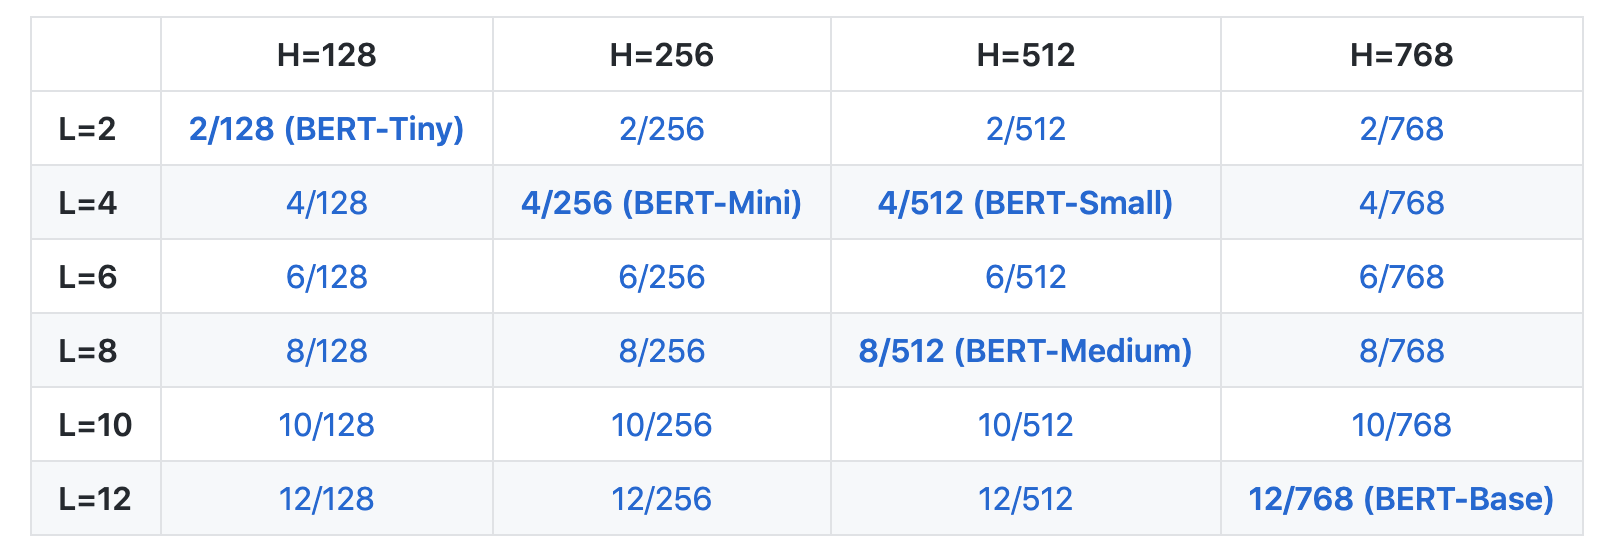

In [14]:
document_assembler = DocumentAssembler() \
    .setInputCol("description") \
    .setOutputCol("document")
    
tokenizer = Tokenizer() \
  .setInputCols(["document"]) \
  .setOutputCol("token")
    
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)

lemma = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma")
    

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [15]:
document_assembler = DocumentAssembler() \
    .setInputCol("description") \
    .setOutputCol("document")
    
tokenizer = Tokenizer() \
  .setInputCols(["document"]) \
  .setOutputCol("token")
    
bert_embeddings = BertEmbeddings().pretrained(name='small_bert_L4_256', lang='en') \
 .setInputCols(["document",'token'])\
 .setOutputCol("embeddings")

embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["document", "embeddings"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE")

classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("category")\
  .setMaxEpochs(10)\
  .setLr(0.001)\
  .setBatchSize(8)\
  .setEnableOutputLogs(True)
  #.setOutputLogsPath('logs')

bert_clf_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            bert_embeddings,
            embeddingsSentence,
            classsifierdl])

small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
[OK!]


In [ ]:
# training will take some time due to Bert (use GPU runtime when possible)

bert_clf_pipelineModel = bert_clf_pipeline.fit(trainDataset)

In [ ]:
!cd /root/annotator_logs && ls -lt 

total 4
-rw-r--r-- 1 root root 839 Oct  8 14:10 ClassifierDLApproach_98046f895f88.log


In [ ]:
!cat /root/annotator_logs/ClassifierDLApproach_98046f895f88.log

Training started - epochs: 10 - learning_rate: 0.001 - batch_size: 8 - training_examples: 120000 - classes: 4
Epoch 0/10 - 118.77s - loss: 13319.663 - acc: 0.85449165 - batches: 15000
Epoch 1/10 - 119.66s - loss: 13078.354 - acc: 0.8694417 - batches: 15000
Epoch 2/10 - 118.86s - loss: 12974.273 - acc: 0.87655 - batches: 15000
Epoch 3/10 - 119.13s - loss: 12904.726 - acc: 0.881825 - batches: 15000
Epoch 4/10 - 119.71s - loss: 12857.29 - acc: 0.88579166 - batches: 15000
Epoch 5/10 - 118.96s - loss: 12811.274 - acc: 0.889175 - batches: 15000
Epoch 6/10 - 119.61s - loss: 12773.1455 - acc: 0.89219165 - batches: 15000
Epoch 7/10 - 118.52s - loss: 12742.098 - acc: 0.8946667 - batches: 15000
Epoch 8/10 - 120.82s - loss: 12716.368 - acc: 0.8968667 - batches: 15000
Epoch 9/10 - 118.80s - loss: 12694.053 - acc: 0.8987833 - batches: 15000


In [ ]:
# We are going to use sklearn to evalute the results on test dataset
from sklearn.metrics import classification_report

preds = bert_clf_pipelineModel.transform(testDataset)

preds_df = preds.select('category','description',"class.result").toPandas()

preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

print (classification_report(preds_df['result'], preds_df['category']))


              precision    recall  f1-score   support

    Business       0.81      0.85      0.83      1809
    Sci/Tech       0.87      0.84      0.85      1955
      Sports       0.97      0.92      0.94      2011
       World       0.86      0.90      0.88      1825

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



## ClassifierDL with Universal Sentence Embeddings

In [ ]:
# actual content is inside description column
document = DocumentAssembler()\
    .setInputCol("description")\
    .setOutputCol("document")
    
# we can also use sentece detector here if we want to train on and get predictions for each sentence

use = UniversalSentenceEncoder.pretrained()\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("category")\
  .setMaxEpochs(5)\
  .setLr(0.001)\
  .setBatchSize(8)\
  .setEnableOutputLogs(True)

use_clf_pipeline = Pipeline(
    stages = [
        document,
        use,
        classsifierdl
    ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [ ]:
use_pipelineModel = use_clf_pipeline.fit(trainDataset)
# 5 epochs takes around 10 min

In [ ]:
!cd ~/annotator_logs && ls -l


total 4
-rw-r--r-- 1 root root 533 Jul 27 13:13 ClassifierDLApproach_524181565fd1.log


In [ ]:
!cat ~/annotator_logs/ClassifierDLApproach_524181565fd1.log


Training started - total epochs: 5 - learning rate: 0.005 - batch size: 64 - training examples: 120000
Epoch 0/5 - 36.532174881%.2fs - loss: 1624.0251 - accuracy: 0.8813 - batches: 1875
Epoch 1/5 - 34.372610287%.2fs - loss: 1597.7561 - accuracy: 0.89163333 - batches: 1875
Epoch 2/5 - 34.589534466%.2fs - loss: 1594.4141 - accuracy: 0.89676666 - batches: 1875
Epoch 3/5 - 34.977971503%.2fs - loss: 1586.4642 - accuracy: 0.90078336 - batches: 1875
Epoch 4/5 - 34.267461476%.2fs - loss: 1581.4093 - accuracy: 0.9034333 - batches: 1875


### with BertSentenceEmbeddings

In [ ]:
# actual content is inside description column
document = DocumentAssembler()\
    .setInputCol("description")\
    .setOutputCol("document")
    
# we can also use sentece detector here if we want to train on and get predictions for each sentence

bert_sent = BertSentenceEmbeddings.pretrained('sent_small_bert_L8_512')\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("category")\
  .setMaxEpochs(20)\
  .setEnableOutputLogs(True)

bert_sent_clf_pipeline = Pipeline(
    stages = [
        document,
        bert_sent,
        classsifierdl
    ])

sent_small_bert_L8_512 download started this may take some time.
Approximate size to download 149.1 MB
[OK!]


In [ ]:
bert_sent_pipelineModel = bert_sent_clf_pipeline.fit(trainDataset)


In [ ]:
# We are going to use sklearn to evalute the results on test dataset
from sklearn.metrics import classification_report

preds = bert_sent_pipelineModel.transform(testDataset)

preds_df = preds.select('category','description',"class.result").toPandas()

preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

print (classification_report(preds_df['result'], preds_df['category']))


              precision    recall  f1-score   support

    Business       0.84      0.86      0.85      1859
    Sci/Tech       0.89      0.84      0.86      2004
      Sports       0.97      0.95      0.96      1946
       World       0.87      0.92      0.89      1791

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



## Getting prediction from Trained model

In [ ]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(use_pipelineModel)

In [ ]:
testDataset.select('description').take(2)

[Row(description="Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."),
 Row(description=' TORONTO, Canada    A second team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for privately funded suborbital space flight, has officially announced the first launch date for its manned rocket.')]

In [ ]:
text='''
Fearing the fate of Italy, the centre-right government has threatened to be merciless with those who flout tough restrictions. 
As of Wednesday it will also include all shops being closed across Greece, with the exception of supermarkets. Banks, pharmacies, pet-stores, mobile phone stores, opticians, bakers, mini-markets, couriers and food delivery outlets are among the few that will also be allowed to remain open.
'''
result = light_model.annotate(text)

result['class']

['Business']

In [ ]:
light_model.annotate('the soccer games will be postponed.')

{'class': ['Sports'],
 'document': ['the soccer games will be postponed.'],
 'sentence_embeddings': ['the soccer games will be postponed.']}

### Saving & loading back the trained model

In [ ]:
use_pipelineModel.stages

[DocumentAssembler_6cc38ac825d2,
 UNIVERSAL_SENTENCE_ENCODER_4de71669b7ec,
 ClassifierDLModel_fa413e291c22]

In [ ]:
use_pipelineModel.stages[2].write().overwrite().save('ClassifierDL_USE_20200727_e5')

In [ ]:
classsifierdlmodel = ClassifierDLModel.load('ClassifierDL_USE_20200727_e5')

In [ ]:
clf_lp = get_clf_lp('ClassifierDL_USE_20200727_e5', sentiment_dl=False,  pretrained=False)


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [ ]:
clf_lp.annotate(text)['class']

['Business']

# SentimentDL Classifier

see also here >> `https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/jupyter/training/english/classification/SentimentDL_train_multiclass_sentiment_classifier.ipynb`

In [17]:

!wget -q aclimdb_train.csv https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sentiment-corpus/aclimdb/aclimdb_train.csv
!wget -q aclimdb_test.csv https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sentiment-corpus/aclimdb/aclimdb_test.csv

In [18]:
trainDataset = spark.read \
      .option("header", True) \
      .csv("aclimdb_train.csv")

trainDataset.show()

+--------------------+--------+
|                text|   label|
+--------------------+--------+
|This is an Excell...|positive|
|The Sarah Silverm...|positive|
|"Prom Night" is a...|negative|
|So often a band w...|positive|
|"Pet Sematary" is...|positive|
|I watched the fil...|negative|
|Boy this movie ha...|negative|
|Checking the spoi...|negative|
|Despite its rathe...|positive|
|Absolute masterpi...|positive|
|The tweedy profes...|positive|
|A movie best summ...|negative|
|Take young, prett...|negative|
|For months I've b...|negative|
|"Batman: The Myst...|positive|
|Well, it was funn...|negative|
|I have seen the s...|positive|
|Brainless film ab...|negative|
|Leave it to geniu...|negative|
|Seven Pounds star...|positive|
+--------------------+--------+
only showing top 20 rows



In [ ]:
# actual content is inside description column
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

use = UniversalSentenceEncoder.pretrained() \
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
sentimentdl = SentimentDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("label")\
  .setMaxEpochs(5)\
  .setEnableOutputLogs(True)

pipeline = Pipeline(
    stages = [
        document,
        use,
        sentimentdl
    ])


In [ ]:
pipelineModel = pipeline.fit(trainDataset)


# MultiLabel Classifier

see also here >> `https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/jupyter/training/english/classification/MultiClassifierDL_train_multi_label_toxic_classifier.ipynb`

In [ ]:
!curl -O 'https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/toxic_comments/toxic_train.snappy.parquet'
!curl -O 'https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/toxic_comments/toxic_test.snappy.parquet'

In [ ]:
trainDataset = spark.read.parquet("/content/toxic_train.snappy.parquet").repartition(120)
testDataset = spark.read.parquet("/content/toxic_test.snappy.parquet").repartition(10)

In [ ]:
# Let's use shrink to remove new lines in the comments
document = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")\
  .setCleanupMode("shrink")

# Here we use the state-of-the-art Universal Sentence Encoder model from TF Hub
embeddings = UniversalSentenceEncoder.pretrained() \
  .setInputCols(["document"])\
  .setOutputCol("sentence_embeddings")

# We will use MultiClassifierDL built by using Bidirectional GRU and CNNs inside TensorFlow that supports up to 100 classes
# We will use only 5 Epochs but feel free to increase it on your own dataset
multiClassifier = MultiClassifierDLApproach()\
  .setInputCols("sentence_embeddings")\
  .setOutputCol("category")\
  .setLabelColumn("labels")\
  .setBatchSize(128)\
  .setMaxEpochs(5)\
  .setLr(1e-3)\
  .setThreshold(0.5)\
  .setShufflePerEpoch(False)\
  .setEnableOutputLogs(True)\
  .setValidationSplit(0.1)

pipeline = Pipeline(
    stages = [
        document,
        embeddings,
        multiClassifier
    ])

In [ ]:
pipelineModel = pipeline.fit(trainDataset)

In [ ]:
print(pipeline.fit(testDataset).stages[2].getClasses())
# >> ['toxic', 'severe_toxic', 'identity_hate', 'insult', 'obscene', 'threat']

In [ ]:
# pred output: [toxic, obscene]

# Case Study: Conference Title Classification 

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/data/title_conference.csv

In [ ]:
import pandas as pd
df = pd.read_csv('title_conference.csv')
df

,Title,Conference
0,Innovation in Database Management: Computer Sc...,VLDB
1,High performance prime field multiplication fo...,ISCAS
2,enchanted scissors: a scissor interface for su...,SIGGRAPH
3,Detection of channel degradation attack by Int...,INFOCOM
4,Pinning a Complex Network through the Betweenn...,ISCAS
...,...,...
2502,A new QR-decomposition based recursive frequen...,ISCAS
2503,CNN Implementation of Spin Filters for Electro...,ISCAS
2504,FaceKit: A Database Interface Design Toolkit.,VLDB
2505,On the trade-off between the number of scrolls...,ISCAS


In [ ]:
df.Conference.value_counts()

ISCAS       864
INFOCOM     515
VLDB        423
WWW         379
SIGGRAPH    326
Name: Conference, dtype: int64

In [ ]:

trainDataset = spark.read \
      .option("header", True) \
      .csv("title_conference.csv")

(trainingData, testData) = trainDataset.randomSplit([0.8, 0.2], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))


Training Dataset Count: 1999
Test Dataset Count: 508


In [ ]:
document = DocumentAssembler()\
    .setInputCol("Title")\
    .setOutputCol("document")
    
# we can also use sentece detector here if we want to train on and get predictions for each sentence

use = UniversalSentenceEncoder.pretrained()\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("Conference")\
  .setMaxEpochs(20)\
  .setEnableOutputLogs(True)

use_clf_pipeline = Pipeline(
    stages = [
        document,
        use,
        classsifierdl
    ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [ ]:
%%time

use_pipelineModel = use_clf_pipeline.fit(trainingData)

# 20 epochs takes around 22 seconds !

CPU times: user 20.9 ms, sys: 6.29 ms, total: 27.2 ms
Wall time: 22.4 s


In [ ]:
preds = use_pipelineModel.transform(testData)

preds.select('Title','Conference',"class.result").show(10, truncate=80)


+--------------------------------------------------------------------------------+----------+----------+
|                                                                           Title|Conference|    result|
+--------------------------------------------------------------------------------+----------+----------+
|                        "Home grown CGI: the cultivation of ""Henry's Garden""."|  SIGGRAPH|[SIGGRAPH]|
|"Restful web services vs. ""big""' web services: making the right architectur...|       WWW|     [WWW]|
|                           "tangible workbench ""TW"": with changeable markers."|  SIGGRAPH|   [ISCAS]|
|                                     0.5V wavelet filters using current mirrors.|     ISCAS|[SIGGRAPH]|
|                    11 GHz UGBW Op-amp with feed-forward compensation technique.|     ISCAS|   [ISCAS]|
|                                      3D facial animation from high speed video.|  SIGGRAPH|[SIGGRAPH]|
|               3D reconstruction of intricate objects 

In [ ]:
# We are going to use sklearn to evalute the results on test dataset
preds_df = preds.select('Conference','Title',"class.result").toPandas()

# Let's explode the array and get the item(s) inside of result column out
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

from sklearn.metrics import classification_report

print (classification_report(preds_df['result'], preds_df['Conference']))


              precision    recall  f1-score   support

     INFOCOM       0.69      0.64      0.67        98
       ISCAS       0.79      0.81      0.80       178
    SIGGRAPH       0.79      0.75      0.77        85
        VLDB       0.61      0.56      0.58        88
         WWW       0.51      0.64      0.57        59

    accuracy                           0.70       508
   macro avg       0.68      0.68      0.68       508
weighted avg       0.71      0.70      0.71       508



In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

preds = pd.DataFrame(confusion_matrix(preds_df['result'], preds_df['Conference']), columns = np.unique(preds_df['Conference']), index =  np.unique(preds_df['Conference']))
preds

,INFOCOM,ISCAS,SIGGRAPH,VLDB,WWW
INFOCOM,63,14,2,14,5
ISCAS,12,144,10,7,5
SIGGRAPH,3,13,64,2,3
VLDB,5,10,1,49,23
WWW,8,1,4,8,38


### Bert Sentence Embeddings

In [ ]:
document = DocumentAssembler()\
    .setInputCol("Title")\
    .setOutputCol("document")
    
bert_sent = BertSentenceEmbeddings.pretrained('sent_small_bert_L8_512')\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("Conference")\
  .setMaxEpochs(20)\
  .setLr(0.001)\
  .setBatchSize(8)\
  .setEnableOutputLogs(True)

bert_clf_pipeline = Pipeline(
    stages = [
        document,
        bert_sent,
        classsifierdl
    ])

sent_small_bert_L8_512 download started this may take some time.
Approximate size to download 149.1 MB
[OK!]


In [ ]:
classsifierdl.getMaxEpochs()

20

In [ ]:
%%time
#20 epochs 30 sec !

bert_pipelineModel = bert_clf_pipeline.fit(trainingData)


CPU times: user 24.8 ms, sys: 3.03 ms, total: 27.8 ms
Wall time: 28.9 s


In [ ]:

from sklearn.metrics import classification_report

preds = bert_pipelineModel.transform(testData)

preds_df = preds.select('Conference',"class.result").toPandas()

preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

print (classification_report(preds_df['result'], preds_df['Conference']))


              precision    recall  f1-score   support

     INFOCOM       0.69      0.68      0.69        92
       ISCAS       0.83      0.84      0.84       179
    SIGGRAPH       0.79      0.74      0.76        87
        VLDB       0.61      0.58      0.59        85
         WWW       0.61      0.69      0.65        65

    accuracy                           0.73       508
   macro avg       0.71      0.71      0.71       508
weighted avg       0.73      0.73      0.73       508

